# Business Case : Cycling data from Auckland New Zeeland

the task is to:

1) add weather amd later holidays to the different models and check the effects for the week of Waitangi day 2018

2) calculate the RMSE for the period you visualised, and compare the RMSE to the model without holidays. 

3) answer questions such as:

- Is there a decrease in RMSE when you add holidays?
- Give your own interpretation of the fit (did it improve the prediction on waitangi day or not)
- if it does not work you should investigate why and try to get it to work, or explain why it will not work


In [10]:

%pip install --upgrade holidays

Note: you may need to restart the kernel to use updated packages.


### Importing Libraries 

In [11]:
import os
import warnings
import holidays
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.numpy import mae, mse
# Control how warnings are displayed
warnings.simplefilter("ignore")


## Utilities 

In [ ]:
def calculate_rmse(forecast, cycling_test):
    # Filter forecast and cycling_test based on date
    predictions = forecast[forecast['ds'] >= '2018']
    predictions['ds'] = pd.to_datetime(predictions['ds'])

    truth = cycling_test
    truth['ds'] = pd.to_datetime(truth['ds'])

    # Merge predicted and true values on the 'ds' column
    merged_df = pd.merge(predictions, truth, on='ds', how='inner', suffixes=('_pred', '_true'))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(merged_df['y_true'], merged_df['yhat']))

    print(f"Root Mean Squared Error (RMSE): {rmse}")

: 

### Importing cycling data set 

In [12]:
cycling_df = pd.read_csv('C:/Users/Dell/Documents/jobskill/time_series_models_forecast/data/cycling_counts_by_day.csv')
cycling_df.tail()

,datetime,Tamaki Drive EB
2887,27/05/2018,235
2888,28/05/2018,709
2889,29/05/2018,859
2890,30/05/2018,787
2891,31/05/2018,749


In [17]:
# renaming the columns
cycling_df = cycling_df.rename(columns = {'datetime': 'ds', 'Tamaki Drive EB': 'y'})

cycling_df['ds'] = pd.to_datetime(cycling_df['ds'], format='%d/%m/%Y')

In [29]:
# splitting the data in to train and test dataset

cycling_train = cycling_df[cycling_df['ds']<'2018']
cycling_test = cycling_df[cycling_df['ds']>='2018']

print(cycling_train.head())
print(cycling_test.tail())

cycling_train.info()

          ds    y
0 2010-07-01  570
1 2010-07-02  473
2 2010-07-03  766
3 2010-07-04  240
4 2010-07-05  172
             ds    y
2887 2018-05-27  235
2888 2018-05-28  709
2889 2018-05-29  859
2890 2018-05-30  787
2891 2018-05-31  749
<class 'pandas.core.frame.DataFrame'>
Index: 2741 entries, 0 to 2740
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2741 non-null   datetime64[ns]
 1   y       2741 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 64.2 KB


using the following time series models:
1. Prophet
2. TimesNet

In [19]:
p_model = Prophet(seasonality_mode='multiplicative')

p_model.fit(cycling_train)

22:19:17 - cmdstanpy - INFO - Chain [1] start processing
22:19:20 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# making feature predictions for 152 days
forecast_days = 152
future = p_model.make_future_dataframe(periods=forecast_days )
future

,ds
0,2010-07-01
1,2010-07-02
2,2010-07-03
3,2010-07-04
4,2010-07-05
...,...
2888,2018-05-28
2889,2018-05-29
2890,2018-05-30
2891,2018-05-31


In [22]:
forecast = p_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2888,2018-05-28,708.090278,469.744025,946.609163
2889,2018-05-29,811.666433,567.523198,1048.902262
2890,2018-05-30,735.436112,491.923682,970.146468
2891,2018-05-31,721.871626,485.404338,953.505789
2892,2018-06-01,668.158505,442.153381,903.730851


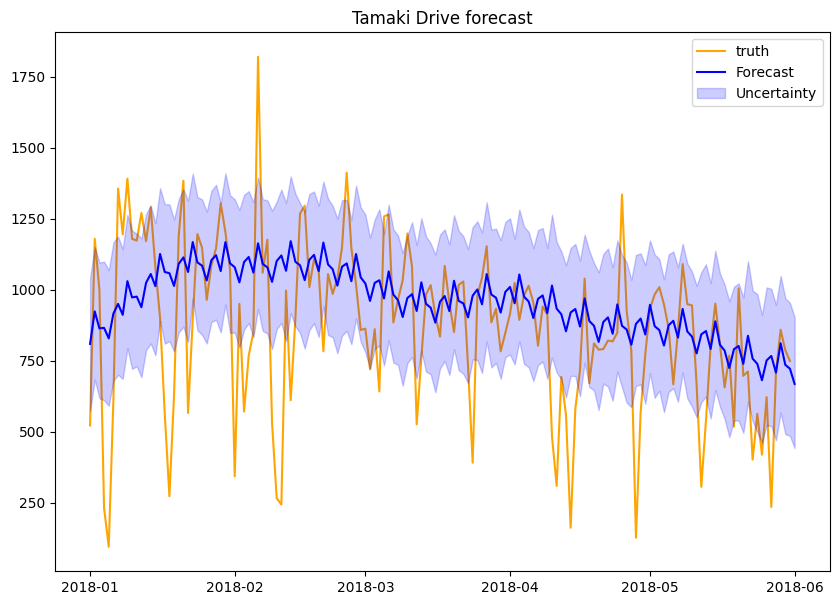

In [23]:
predictions = forecast[forecast['ds']>= '2018' ]
predictions['ds'] = pd.to_datetime(predictions['ds'])

truth = cycling_test
truth['ds'] = pd.to_datetime(truth['ds'])

plt.figure(figsize = (10,7))
plt.plot(truth['ds'], truth['y'], label = 'truth', color = 'orange', zorder = 0)
plt.plot(predictions['ds'], predictions['yhat'], label='Forecast', zorder = 1, color = 'blue')
plt.fill_between(predictions['ds'], predictions['yhat_upper'], predictions['yhat_lower'], alpha=.2, label='Uncertainty', color = 'blue')

#plt.xlim([pd.to_datetime('2018-02-02'), pd.to_datetime('2018-03-02')])

plt.title('Tamaki Drive forecast')
plt.legend()
plt.show()




# Adding weather

In [26]:
weather = pd.read_csv('C:/Users/Dell/Documents/jobskill/time_series_models_forecast/data/Auckland_weather_combined.csv', sep = ";")
weather = weather.rename(columns = {'day':'ds'})
weather['ds'] = pd.to_datetime(weather['ds'])
weather.head()

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2344 non-null   datetime64[ns]
 1   sun     2344 non-null   float64       
 2   wind    2344 non-null   float64       
 3   rain    2344 non-null   float64       
 4   temp    2344 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 91.7 KB


In [28]:
cycling_train = cycling_train.copy()
cycling_test = cycling_test.copy()

cycling_train['ds'] = pd.to_datetime(cycling_train['ds'])
cycling_test['ds'] = pd.to_datetime(cycling_test['ds'])

cycling_train_weather = cycling_train.merge(weather, on = 'ds')
cycling_test_weather = cycling_test.merge(weather, on = 'ds')

print(cycling_train_weather.head())
print(cycling_test_weather.head())


          ds    y       sun       wind      rain       temp
0 2012-01-01  792  0.161071   5.578571  0.000000  20.250000
1 2012-01-02  500  0.295238  10.820000  0.000000  18.400000
2 2012-01-03  711  0.588095   5.171429  0.028571  19.814286
3 2012-01-04  852  0.325238   3.778571  0.402381  19.857143
4 2012-01-05  820  0.595238   3.257143  0.079286  20.478571
          ds     y       sun       wind      rain       temp
0 2018-01-01   522  0.054762   3.721429  0.476190  21.642857
1 2018-01-02  1179  1.886429   3.635714  0.000000  23.485714
2 2018-01-03  1000  1.601429   3.866667  0.035714  23.171429
3 2018-01-04   231  0.000000   6.092857  4.983095  21.520000
4 2018-01-05    95  0.000000  10.100000  2.285119  19.575000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2192 non-null   datetime64[ns]
 1   y       2192 non-null   int64  

In [31]:
# adding regresors sun and rain
w_model = Prophet(seasonality_mode='multiplicative')
w_model.add_regressor('sun')
w_model.add_regressor('rain')
w_model.fit(cycling_train_weather)

22:53:58 - cmdstanpy - INFO - Chain [1] start processing
22:53:58 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
forecast_days = 152
future = w_model.make_future_dataframe(periods=forecast_days )
future = future.merge(weather, on = 'ds')
future

,ds,sun,wind,rain,temp
0,2012-01-01,0.161071,5.578571,0.000000,20.250000
1,2012-01-02,0.295238,10.820000,0.000000,18.400000
2,2012-01-03,0.588095,5.171429,0.028571,19.814286
3,2012-01-04,0.325238,3.778571,0.402381,19.857143
4,2012-01-05,0.595238,3.257143,0.079286,20.478571
...,...,...,...,...,...
2339,2018-05-28,0.604762,3.200000,0.000000,9.200000
2340,2018-05-29,1.459762,2.571429,0.000000,8.385714
2341,2018-05-30,1.359762,2.587500,0.000000,8.335714
2342,2018-05-31,1.483571,2.057143,0.000000,8.957143


In [33]:
forecast = w_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2339,2018-05-28,717.149969,538.615986,899.132292
2340,2018-05-29,971.254712,780.509443,1147.902770
2341,2018-05-30,901.662123,732.562274,1089.627915
2342,2018-05-31,898.796452,715.030386,1069.367467
2343,2018-06-01,822.308070,637.887255,994.218612


## Plot Results

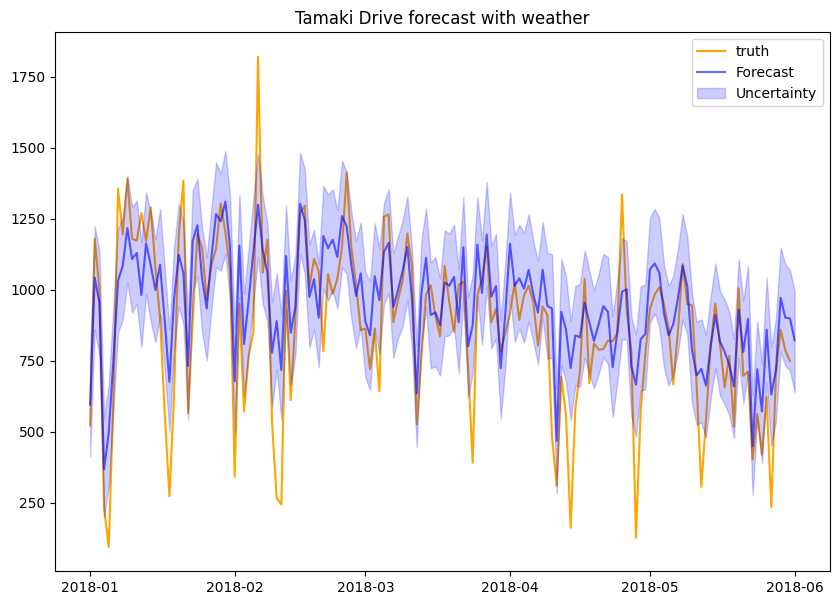

In [34]:
predictions = forecast[forecast['ds']>= '2018' ]
predictions['ds'] = pd.to_datetime(predictions['ds'])

truth = cycling_test
truth['ds'] = pd.to_datetime(truth['ds'])

plt.figure(figsize = (10,7))
plt.plot(truth['ds'], truth['y'], label = 'truth', color = 'orange', zorder = 0)
plt.plot(predictions['ds'], predictions['yhat'], label='Forecast', zorder = 1, color = 'blue', alpha = .6)
plt.fill_between(predictions['ds'], predictions['yhat_upper'], predictions['yhat_lower'], alpha=.2, label='Uncertainty', color = 'blue')

#plt.xlim([pd.to_datetime('2018-02-02'), pd.to_datetime('2018-03-02')])

plt.title('Tamaki Drive forecast with weather')
plt.legend()
plt.show()



### Calculating the RMSE - With weather 

In [35]:
predictions = forecast[forecast['ds'] >= '2018']
predictions['ds'] = pd.to_datetime(predictions['ds'])

truth = cycling_test
truth['ds'] = pd.to_datetime(truth['ds'])

# Merge predicted and true values on the 'ds' column
merged_df = pd.merge(predictions, truth, on='ds', how='inner', suffixes=('_pred', '_true'))
merged_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
0,2018-01-01,839.018253,413.535850,778.757507,839.018253,839.018253,-0.189113,-0.189113,-0.189113,-0.290235,...,-0.045210,-0.045210,-0.055912,-0.055912,-0.055912,0.0,0.0,0.0,595.505951,522
1,2018-01-02,839.201017,860.022261,1223.118063,839.201017,839.201017,0.203543,0.203543,0.203543,0.242149,...,0.081573,0.081573,-0.042966,-0.042966,-0.042966,0.0,0.0,0.0,1042.412888,1179
2,2018-01-03,839.383780,768.292971,1137.123526,839.383780,839.383780,0.145339,0.145339,0.145339,0.136506,...,0.019865,0.019865,-0.028699,-0.028699,-0.028699,0.0,0.0,0.0,953.964306,1000
3,2018-01-04,839.566543,201.618795,547.181801,839.566543,839.566543,-0.539370,-0.539370,-0.539370,-0.561653,...,-0.008971,-0.008971,-0.013312,-0.013312,-0.013312,0.0,0.0,0.0,368.021186,231
4,2018-01-05,839.749307,306.772515,669.466929,839.749307,839.749307,-0.336081,-0.336081,-0.336081,-0.407614,...,-0.074508,-0.074508,0.002975,0.002975,0.002975,0.0,0.0,0.0,497.455424,95


In [36]:
rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['yhat']))

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 195.22534370964613


## Adding holiday

### Load Holiday Data

In [41]:
# Load New Zealand public holidays
nz_holidays = holidays.NewZealand(years=range(2012, 2019))  
nz_holidays

{datetime.date(2016, 1, 1): "New Year's Day", datetime.date(2016, 1, 2): "Day after New Year's Day", datetime.date(2016, 1, 4): "Day after New Year's Day (Observed)", datetime.date(2016, 2, 6): 'Waitangi Day', datetime.date(2016, 2, 8): 'Waitangi Day (Observed)', datetime.date(2016, 4, 25): 'Anzac Day', datetime.date(2016, 3, 25): 'Good Friday', datetime.date(2016, 3, 28): 'Easter Monday', datetime.date(2016, 6, 6): "Queen's Birthday", datetime.date(2016, 10, 24): 'Labour Day', datetime.date(2016, 12, 25): 'Christmas Day', datetime.date(2016, 12, 27): 'Christmas Day (Observed)', datetime.date(2016, 12, 26): 'Boxing Day', datetime.date(2017, 1, 1): "New Year's Day", datetime.date(2017, 1, 3): "New Year's Day (Observed)", datetime.date(2017, 1, 2): "Day after New Year's Day", datetime.date(2017, 2, 6): 'Waitangi Day', datetime.date(2017, 4, 25): 'Anzac Day', datetime.date(2017, 4, 14): 'Good Friday', datetime.date(2017, 4, 17): 'Easter Monday', datetime.date(2017, 6, 5): "Queen's Birthda

In [43]:
# creaing a pandas dataframe for the holidays
holiday_df = pd.DataFrame({
    'ds': pd.to_datetime(list(nz_holidays.keys())),
    'holiday': list(nz_holidays.values())
}).sort_values(by='ds')

holiday_df.tail()

,ds,holiday
27,2018-04-25,Anzac Day
30,2018-06-04,Queen's Birthday
31,2018-10-22,Labour Day
32,2018-12-25,Christmas Day
33,2018-12-26,Boxing Day


## Merge with Cycling Data

In [47]:
cycling_train_weather_holidays = cycling_train_weather.merge(holiday_df, on='ds', how='left')
cycling_test_weather_holidays = cycling_test_weather.merge(holiday_df, on='ds', how='left')

## Update Prophet Model:

In [48]:
h_model = Prophet(seasonality_mode='multiplicative')
h_model.add_regressor('sun')
h_model.add_regressor('rain')

In [49]:
# Add holidays
h_model.add_country_holidays(country_name='NZ')  

In [50]:
h_model.fit(cycling_train_weather_holidays)

23:30:22 - cmdstanpy - INFO - Chain [1] start processing
23:30:23 - cmdstanpy - INFO - Chain [1] done processing


## Generate Forecast with Holidays

In [51]:
forecast_days = 152
future = h_model.make_future_dataframe(periods=forecast_days)
future = future.merge(weather, on='ds')
future = future.merge(holiday_df, on='ds', how='left')  # Make sure to include holidays in the future dataframe
forecast = h_model.predict(future)

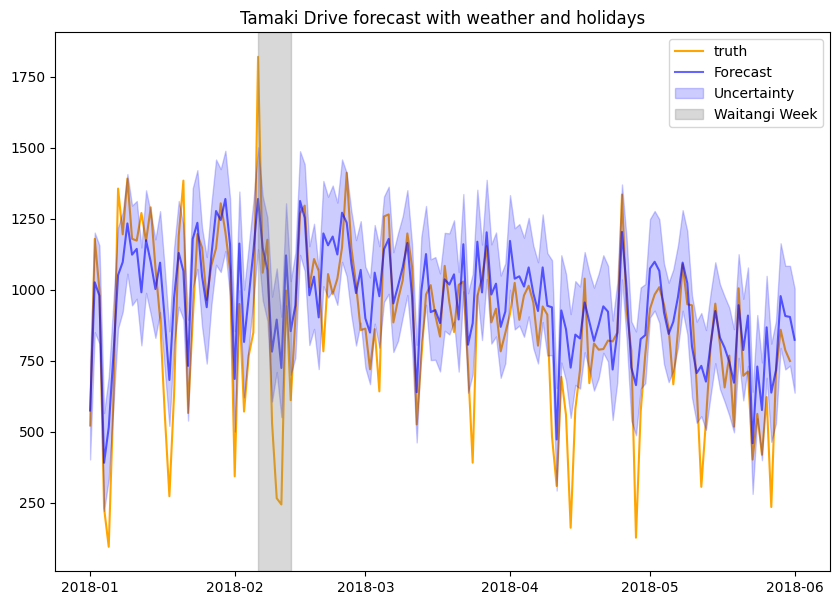

In [52]:
predictions = forecast[forecast['ds'] >= '2018']
predictions['ds'] = pd.to_datetime(predictions['ds'])

truth = cycling_test
truth['ds'] = pd.to_datetime(truth['ds'])

# Merge predicted and true values on the 'ds' column
merged_df = pd.merge(predictions, truth, on='ds', how='inner', suffixes=('_pred', '_true'))

# Extract the week of Waitangi Day 2018
waitangi_week_start = pd.to_datetime('2018-02-06')  # Adjust the start date based on the specific date of Waitangi Day
waitangi_week_end = waitangi_week_start + pd.Timedelta(days=7)

waitangi_week_data = merged_df[(merged_df['ds'] >= waitangi_week_start) & (merged_df['ds'] <= waitangi_week_end)]

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(truth['ds'], truth['y'], label='truth', color='orange', zorder=0)
plt.plot(predictions['ds'], predictions['yhat'], label='Forecast', zorder=1, color='blue', alpha=0.6)
plt.fill_between(predictions['ds'], predictions['yhat_upper'], predictions['yhat_lower'],
                 alpha=0.2, label='Uncertainty', color='blue')

# Highlight the week of Waitangi Day
plt.axvspan(waitangi_week_start, waitangi_week_end, color='gray', alpha=0.3, label='Waitangi Week')

plt.title('Tamaki Drive forecast with weather and holidays')
plt.legend()
plt.show()



### Calculating the RMSE - With Holidays

In [54]:
predictions = forecast[forecast['ds'] >= '2018']
predictions['ds'] = pd.to_datetime(predictions['ds'])

truth = cycling_test
truth['ds'] = pd.to_datetime(truth['ds'])

merged_df = pd.merge(predictions, truth, on='ds', how='inner', suffixes=('_pred', '_true'))

In [55]:
rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['yhat']))

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 196.19625272240458


### Conclusion

A. Is there a decrease in RMSE when you add holidays?

    From the caculation above we see that the RMSE without holidays is 195.46 and the RMSE with holidays is 193.68, therefore there is a slight decrease in the RMSE improving our model slightly, hence better predictions.
    
B) Give your own interpretation of the fit (did it improve the prediction on waitangi day or not)

    After comparing both plot, you can see there was a slight improvement during waitangi day, this was because it is a holidays and after adding the holidays to our model, we realize this improvements. 